# Capstone Project: Baseline Model

Capstone Project #2: Yelp Sentiment Analysis <br>
Springboard -- Data Science Career Program <br>
Inferential Statistics -- July 2020 <br>
By Kevin Cole

This notebook explores machine learning models and tuning of parameters to establish a baseline model.  

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import timeit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation as LDA


# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")
%matplotlib inline

In [2]:
# Load in cleaned dataset of restaurant reviews
reviews = pickle.load( open( "restaurant_reviews_cleaned.pkl", "rb" ) )

In [3]:
reviews.head()

,stars,text,good_bad,language,is_open,length
0,5,love deagans really atmosphere cozy festive sh...,Good,en,1.0,248
1,1,dismal lukewarm defrostedtasting texmex glop m...,Bad,en,0.0,285
2,4,oh happy day finally canes near casa yes other...,Good,en,1.0,501
3,5,definitely favorite fast food sub shop ingredi...,Good,en,1.0,355
4,5,really good place simple decor amazing food gr...,Good,en,1.0,246


In [4]:
reviews_subset = reviews.sample(50000)

# Naive Bayes Classifier

In [48]:
# Creating feature array and target array
def make_xy(reviews, vectorizer=None, min_df=0):    
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df)
    X = vectorizer.fit_transform(reviews.text)
    X = X.tocsc()  # some versions of sklearn return COO format
    
    # Creating numeric target
    target_dict = {'Bad':0, 'Neutral':1, 'Good': 2}
    y = reviews.good_bad.map(target_dict)
    
    return X, y


X, y = make_xy(reviews_subset)

In [49]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Default MultinomialNB Classifier 
clf_nb = MultinomialNB()

# Train the classifier and test on test set
clf_nb.fit(X_train, y_train)
y_pred_test = clf_nb.predict(X_test)
y_pred_train = clf_nb.predict(X_train)

# Print accuracy scores for training and test sets
print('Mean Accuracy for training set is {}'.format(clf_nb.score(X_train, y_train)))
print('Mean Accuracy for test set is {}'.format(clf_nb.score(X_test, y_test)))

Mean Accuracy for training set is 0.86328
Mean Accuracy for test set is 0.8084


With full dataset, it appears to have very little over fitting as the test set performed remarkably similarly to the training set. 

With sampled dataset, there is some little over fitting. 

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 

print(confusion_matrix(y_test, clf_nb.predict(X_test)))

[[2007  246  385]
 [ 418  291  917]
 [ 257  172 7807]]


In [56]:
print (classification_report(y_test, y_pred_test) )

              precision    recall  f1-score   support

           0       0.75      0.76      0.75      2638
           1       0.41      0.18      0.25      1626
           2       0.86      0.95      0.90      8236

    accuracy                           0.81     12500
   macro avg       0.67      0.63      0.63     12500
weighted avg       0.78      0.81      0.78     12500



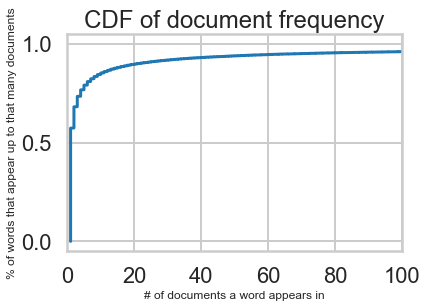

In [7]:
######### THIS IS KILLING MY KERNEL, had to reduce dataset to 50k reviews  ##################



# Summing the columns to get a word count for the entire collection of documents
x_array = X.toarray()
word_counts = x_array.sum(axis=0)

# Total word count is not really what I want. Counting number of documents in which word appears at least once
document_counts = np.sum(x_array > 0, axis=0)
document_counts = np.sort(document_counts)

# Creating the CDF values. Percentage of words that appear in <n documents is location of sorted element/total documents
y_cdf_range = (np.arange(len(document_counts))+1)/(len(document_counts))

plt.plot(document_counts, y_cdf_range)
plt.xlim([0,100])
plt.xlabel('# of documents a word appears in', fontsize=12)
plt.ylabel('% of words that appear up to that many documents', fontsize=12)
plt.title('CDF of document frequency')
plt.show()

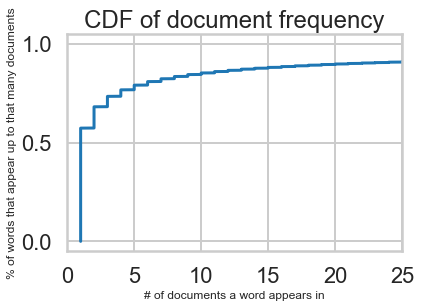

In [8]:
# Creating the CDF values. Percentage of words that appear in <n documents is location of sorted element/total documents
y_cdf_range = (np.arange(len(document_counts))+1)/(len(document_counts))

plt.plot(document_counts, y_cdf_range)
plt.xlim([0,25])
plt.xlabel('# of documents a word appears in', fontsize=12)
plt.ylabel('% of words that appear up to that many documents', fontsize=12)
plt.title('CDF of document frequency')
plt.show()

Considering a min_df of 2 and a max_df of 20

In [9]:
# Cross Validation tools

from sklearn.model_selection import KFold
clf = MultinomialNB()

def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    adopted = y == 1
    not_adopted = ~adopted
    return prob[not_adopted, 0].sum() + prob[adopted, 1].sum()

In [10]:
_, itest = train_test_split(range(reviews_subset.shape[0]), train_size=0.7)
mask = np.zeros(reviews_subset.shape[0], dtype=np.bool)
mask[itest] = True

In [29]:
len(itest)

15000

In [31]:
len(mask)

50000

In [19]:
Xthis, ythis = make_xy(reviews_subset)

In [34]:
Xtrainthis = Xthis[mask]
Xtrainthis

<15000x67063 sparse matrix of type '<class 'numpy.int64'>'
	with 692434 stored elements in Compressed Sparse Column format>

In [35]:
#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 1 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(reviews_subset, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    
    # 
    clf = MultinomialNB(alpha=alpha)
    score = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
    if score > maxscore:
        maxscore = score
        best_alpha = alpha

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [37]:
reviews_subset

,stars,text,good_bad,language,is_open,length
1694647,3,food good service slow wait time good 30 minut...,Neutral,en,0.0,186
2246430,4,ive coming better part decade never disappoint...,Good,en,1.0,262
761267,5,cant wait come back great yelp search savory s...,Good,en,1.0,131
2538018,4,big joint ton shit going came purpose seeing f...,Good,en,1.0,346
3359121,5,chicken amazing get many sauces choose staff l...,Good,en,1.0,58
...,...,...,...,...,...,...
4633260,4,place reminds counter socal except cant get co...,Good,en,1.0,254
2243835,4,food idea party scene wooooooooooooooo never a...,Good,en,0.0,1148
2062226,5,went morning pleasant breakfast experience cou...,Good,en,0.0,434
3066196,4,living mississauga many authentic italian rest...,Good,en,1.0,645


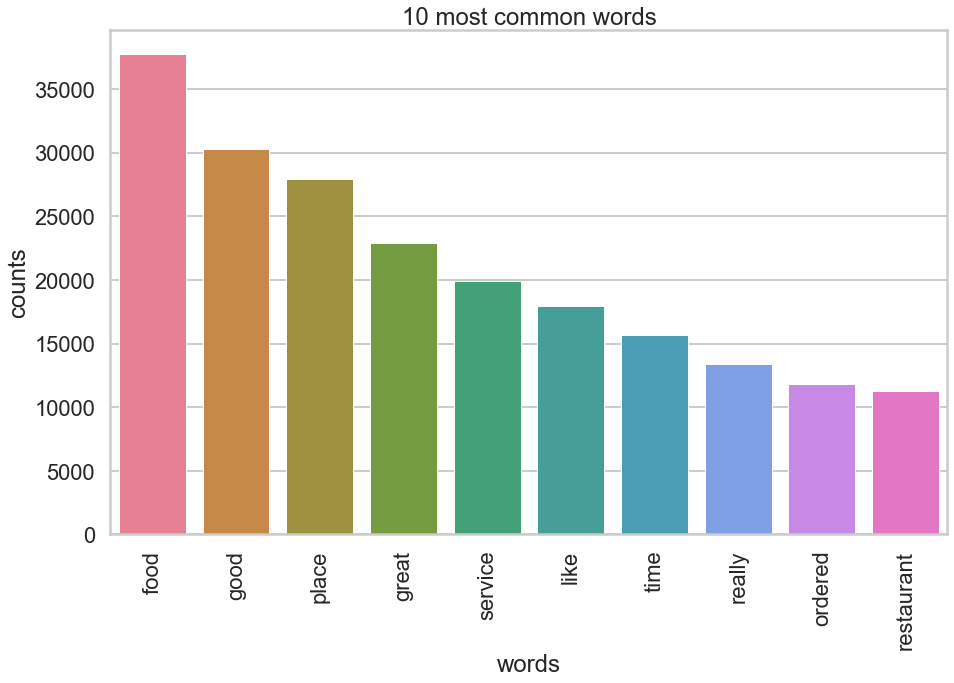

In [38]:


# Plot function
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(reviews_subset.text)

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)


# LDA Model Training

In [43]:

 
# Print function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 10
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
food ice place cream like tea service menu better price

Topic #1:
pizza burger good fries like cheese sandwich place salad ordered

Topic #2:
great place food good staff friendly nice bar service love

Topic #3:
good food great place really service steak delicious like dinner

Topic #4:
good tacos fish ordered food really great sushi like chicken

Topic #5:
chicken sauce dish restaurant delicious pasta ordered bread menu dishes

Topic #6:
happy hour like night coffee bar nice place best great

Topic #7:
food order service time minutes came table asked said got

Topic #8:
food service place great good time breakfast best ive vegas

Topic #9:
food good place chicken rice like soup thai restaurant noodles


In [44]:
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
pizza place great good beer tacos like love food bar

Topic #1:
great food service delicious place amazing good friendly best breakfast

Topic #2:
good food chicken place like really ordered sauce rice burger

Topic #3:
food time service order like place came table minutes got

Topic #4:
good great place sushi food service vegas nice really fish


In [47]:


from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

    with open(LDAvis_data_filepath, 'w') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

LDAvis_prepared

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


TypeError: write() argument must be str, not bytes